In [1]:
import copy

import networkx
import shapely.geometry
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import opentnsim

In [2]:
# We're in engineering cordinates (m)
coords = [
    [0, 0],
    [100000, 0],
    [200000, 0],
    [200000, 150000],
    [200000, 250000],
    [306066, 106066],
    [376777, 176777],
    [350000, 0],
    [450000, 0],
    [217678, -17678],
    [376777, -176777]
]

# these are the indices of the points above
edge_indices = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [2, 5],
    [5, 6],
    [2, 7],
    [7, 8],
    [2, 9],
    [9, 10]   
]

depths = [12.5, 6, 6, 6, 4.5, 6, 2.5, 6, 2.5, 6] 

widths = [300, 150, 150, 150, 150, 150, 150, 150, 150, 150]

In [3]:
points = [
    shapely.geometry.Point(*coord )
    for coord 
    in coords
]

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

FG = nx.DiGraph()
nodes = []
for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(points[index].x, points[index].y)}
    nodes.append(Node(**data_node))

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)    

In [4]:
for index, edge in enumerate(edge_indices):
    edge_geometry = shapely.geometry.LineString([points[edge[0]], points[edge[1]]])
    edge_properties = dict(
        GeneralDepth = depths[index],
        width = widths[index],
        geometry=edge_geometry, 
        length= round(edge_geometry.length),
        e=tuple(edge)
    )
    FG.add_edge("Node " + str(edge[0]), "Node " + str(edge[1]), weight = 1, Info = edge_properties)

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

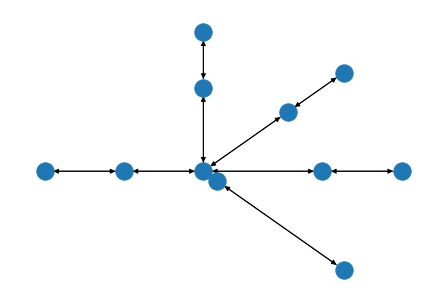

In [5]:
# show graph
nx.draw(FG, positions)
plt.show()

In [6]:
# inspect if properties were set correctly
for edge in FG.edges(data = True):
    print('{}, {}: general depth {} m'.format(edge[0], edge[1], FG.edges[(edge[0], edge[1])]['Info']['GeneralDepth']))

Node 0, Node 1: general depth 12.5 m
Node 1, Node 0: general depth 12.5 m
Node 1, Node 2: general depth 6 m
Node 2, Node 1: general depth 6 m
Node 2, Node 3: general depth 6 m
Node 2, Node 5: general depth 4.5 m
Node 2, Node 7: general depth 2.5 m
Node 2, Node 9: general depth 2.5 m
Node 3, Node 2: general depth 6 m
Node 3, Node 4: general depth 6 m
Node 4, Node 3: general depth 6 m
Node 5, Node 2: general depth 4.5 m
Node 5, Node 6: general depth 6 m
Node 6, Node 5: general depth 6 m
Node 7, Node 2: general depth 2.5 m
Node 7, Node 8: general depth 6 m
Node 8, Node 7: general depth 6 m
Node 9, Node 2: general depth 2.5 m
Node 9, Node 10: general depth 6 m
Node 10, Node 9: general depth 6 m


Edited up to here

In [24]:
edges = []
depths = [12.5, 6, 6, 6, 4.5, 6, 2.5, 6, 2.5, 6] 
widths = [300, 150, 150, 150, 150, 150, 150, 150, 150, 150]
for e in edge_indices:
    edge_geometry = shapely.geometry.LineString([points[e[0]], points[e[1]]])
    edge_properties = dict(
        depth = 12.5,
        width = 300,
        geometry=edge_geometry, 
        length= round(edge_geometry.length),
        e=tuple(e)
    )
    edges.append(edge_properties)

df_edges = pd.DataFrame(edges)
df_edges['depth'] = depths
df_edges['width'] = widths
df_edges

,depth,width,geometry,length,e
0,12.5,300,"LINESTRING (0 0, 100000 0)",100000,"(0, 1)"
1,6.0,150,"LINESTRING (100000 0, 200000 0)",100000,"(1, 2)"
2,6.0,150,"LINESTRING (200000 0, 200000 150000)",150000,"(2, 3)"
3,6.0,150,"LINESTRING (200000 150000, 200000 250000)",100000,"(3, 4)"
4,4.5,150,"LINESTRING (200000 0, 306066 106066)",150000,"(2, 5)"
5,6.0,150,"LINESTRING (306066 106066, 376777 176777)",100000,"(5, 6)"
6,2.5,150,"LINESTRING (200000 0, 350000 0)",150000,"(2, 7)"
7,6.0,150,"LINESTRING (350000 0, 450000 0)",100000,"(7, 8)"
8,2.5,150,"LINESTRING (200000 0, 217678 -17678)",25000,"(2, 9)"
9,6.0,150,"LINESTRING (217678 -17678, 376777 -176777)",225000,"(9, 10)"


In [26]:
graph = nx.DiGraph()

for node in nodes:
    graph.add_node(node['node_i'], **node)
    
# Add up and downstream
for edge in edges:
    graph.add_edge(edge['e'][0], edge['e'][1], **edge)
    graph.add_edge(edge['e'][1], edge['e'][0], **edge)

pos = {
    node['node_i']: (node['x'], node['y']) 
    for node 
    in nodes
}

nx.draw_networkx(graph, pos=pos)


TypeError: 'Site' object is not subscriptable

In [ ]:
row = {
    "rws_type": "M8",
    "fuel": 3000,
    "H2": 999000,
    "Battery": 3300,
    "E-LNG": 432000,
    "E-Methanol": 165900
}
rows = [row]
ships = pd.DataFrame(rows)
ships

In [ ]:
def split_edge(edge, distance=100):
    """compute points (list of shapely points) and edges ({e: linestring}) that we can use to replace an edge by points in between"""
    distances = np.arange(0, edge['geometry'].length + distance, distance)
    
    # The determine the points based on the distances
    points = [
        edge['geometry'].interpolate(distance) 
        for distance 
        in distances
    ]
    
    edges = {}
    # loop over the start, end point pairs
    edge_pairs = list(
        zip(
            points[:-1], 
            points[1:]
        )
    )
    for edge_i, (point_a, point_b) in enumerate(edge_pairs):    
        edge_geometry = shapely.geometry.LineString([point_a, point_b])
        node_a = edge_i
        node_b = edge_i + 1
        edges[(node_a, node_b)] = edge_geometry
    return points, edges

def split_and_replace_edge(graph, edge, distance=100):
    """remove edge from the network and replace it by points in between"""
    # Remember the edge to remove
    e_replace = edge['e']
    # determine the points that we want to intersect
    intersection_points, intersection_edges = split_edge(edge, distance=distance)
    # Try and remove the previous edges, if it fails, that's ok
    try:
        graph.remove_edge(e_replace[0], e_replace[1])
    except nx.NetworkXError:
        pass
    # also remove the oposite edge direction
    try:
        graph.remove_edge(e_replace[1], e_replace[0])
    except nx.NetworkXError:
        pass

    # start at the start of our replaced edge
    nodes = [graph.nodes[e_replace[0]]]
    # all the points in between
    for node_i, point in enumerate(intersection_points[1:-1]):
        node_id = f'{e_replace[0]}-{node_i}-{e_replace[1]}'
        node_properties = dict(
            geometry=point,
            x=point.x,
            y=point.y,
            node_i=node_id
        )
        nodes.append(node_properties)
    # end at the end of our edge
    nodes.append(graph.nodes[e_replace[1]])

    # add all the node properties, skip first and last, because they already exist
    for node in nodes[1:-1]:
        node_i = node['node_i']
        pos[node_i] = [node['x'], node['y']]
        # add the nodes in between
        graph.add_node(node_i, **node)
        
    # now loop over all the node pairs in between our edge
    edges = []
    for node_a, node_b in zip(nodes[:-1], nodes[1:]):
        # this is our new edge
        e = (node_a['node_i'], node_b['node_i'])
        # create a new geometry
        edge_geometry = shapely.geometry.LineString([
            node_a['geometry'], 
            node_b['geometry']
        ])
        # we might want to copy the old properties
        # for now this is hard coded
        # at least replace e, edge_geometry
        edge_properties = dict(
            depth= 12.5, 
            width= 300, 
            geometry=edge_geometry, 
            length=edge_geometry.length,
            e=tuple(e)
        )
        edges.append(edge_properties)

    # now that we have all our edges computed
    for edge in edges:
        # insert them in two directions
        e = edge['e']
        graph.add_edge(e[0], e[1], **edge)
        graph.add_edge(e[1], e[0], **edge)
    
    return edges

In [ ]:

split_edge_0 = split_and_replace_edge(graph, edges[0], distance=1000)
split_edge_1 = split_and_replace_edge(graph, edges[1], distance=1000)
split_edge_2 = split_and_replace_edge(graph, edges[2], distance=1000)
split_edge_3 = split_and_replace_edge(graph, edges[3], distance=1000)
split_edge_4 = split_and_replace_edge(graph, edges[4], distance=1000)
split_edge_5 = split_and_replace_edge(graph, edges[5], distance=1000)
split_edge_6 = split_and_replace_edge(graph, edges[6], distance=1000)
split_edge_7 = split_and_replace_edge(graph, edges[7], distance=1000)
split_edge_8 = split_and_replace_edge(graph, edges[8], distance=1000)
split_edge_9 = split_and_replace_edge(graph, edges[9], distance=1000)

# to do replace depth width for df, https://www.delftstack.com/howto/python-pandas/pandas-replace-values-in-column/
# assign df to the Graph info

In [ ]:
df_split_edge_0 = pd.DataFrame(split_edge_0)
df_split_edge_0

In [ ]:
df_split_edge_1 = pd.DataFrame(split_edge_1)
df_split_edge_1['depth'] = df_split_edge_1['depth'].replace([12.5], 6)
df_split_edge_1['width'] = df_split_edge_1['width'].replace([300], 150)
df_split_edge_1

In [ ]:
df_split_edge_2 = pd.DataFrame(split_edge_2)
df_split_edge_2['depth'] = df_split_edge_2['depth'].replace([12.5], 6)
df_split_edge_2['width'] = df_split_edge_2['width'].replace([300], 150)
df_split_edge_2

In [ ]:
df_split_edge_3 = pd.DataFrame(split_edge_3)
df_split_edge_3['depth'] = df_split_edge_3['depth'].replace([12.5], 6)
df_split_edge_3['width'] = df_split_edge_3['width'].replace([300], 150)
df_split_edge_3

In [ ]:
df_split_edge_4 = pd.DataFrame(split_edge_4)
df_split_edge_4['depth'] = df_split_edge_4['depth'].replace([12.5], 4.5)
df_split_edge_4['width'] = df_split_edge_4['width'].replace([300], 150)
df_split_edge_4

In [ ]:
df_split_edge_5 = pd.DataFrame(split_edge_5)
df_split_edge_5['depth'] = df_split_edge_5['depth'].replace([12.5], 6)
df_split_edge_5['width'] = df_split_edge_5['width'].replace([300], 150)
df_split_edge_5

In [ ]:
df_split_edge_6 = pd.DataFrame(split_edge_6)
df_split_edge_6['depth'] = df_split_edge_6['depth'].replace([12.5], 2.5)
df_split_edge_6['width'] = df_split_edge_6['width'].replace([300], 150)
df_split_edge_6

In [ ]:
df_split_edge_7 = pd.DataFrame(split_edge_7)
df_split_edge_7['depth'] = df_split_edge_7['depth'].replace([12.5], 6)
df_split_edge_7['width'] = df_split_edge_7['width'].replace([300], 150)
df_split_edge_7

In [ ]:
df_split_edge_8 = pd.DataFrame(split_edge_8)
df_split_edge_8['depth'] = df_split_edge_8['depth'].replace([12.5], 2.5)
df_split_edge_8['width'] = df_split_edge_8['width'].replace([300], 150)
df_split_edge_8

In [ ]:
df_split_edge_9 = pd.DataFrame(split_edge_9)
df_split_edge_9['depth'] = df_split_edge_9['depth'].replace([12.5], 6)
df_split_edge_9['width'] = df_split_edge_9['width'].replace([300], 150)
df_split_edge_9

### assign info to edges on the graph

In [ ]:
edges[0]= df_split_edge_0
edges[1]= df_split_edge_1
edges[2]= df_split_edge_2
edges[3]= df_split_edge_3
edges[4]= df_split_edge_4
edges[5]= df_split_edge_5
edges[6]= df_split_edge_6
edges[7]= df_split_edge_7
edges[8]= df_split_edge_8
edges[9]= df_split_edge_9

In [ ]:
print(pd.DataFrame(nodes))

In [ ]:
# df_path_deep =  df_split_edge_0.append(df_split_edge_1).append(df_split_edge_2).append(df_split_edge_3)
# df_path_shallow =  df_split_edge_0.append(df_split_edge_1).append(df_split_edge_4).append(df_split_edge_5)
# df_path_limiting =  df_split_edge_0.append(df_split_edge_1).append(df_split_edge_6).append(df_split_edge_7)
# df_path_short_lim =  df_split_edge_0.append(df_split_edge_1).append(df_split_edge_8).append(df_split_edge_9)

# df_path_deep

In [ ]:
# fig, ax = plt.subplots(figsize=(100, 75))
# # nx.draw_networkx(graph, pos=pos, ax=ax)
# nx.draw(graph, pos=pos, ax=ax)
# plt.savefig('network.pdf', bbox_inches = 'tight', dpi=600, format='pdf')  

### Create vessels - add VesselProperties and ConsumesEnergy mixins

In [ ]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.Routeable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.core.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [ ]:
# Create a dict with all important settings
# NB: set both "v" and "P_tot_given" to None, as they will be set later
# Note that we set "h_squat" as "True". 
# The squat effect makes a great difference for the actual water depth and resistance calculation in shallow water. 
# Here we need to calculate the water depth reduced by squat since what we give the ship is a route with undisturbed water depth h_0.

data_vessel = {"env": None,
               "name": None,
               "route": None,
               "geometry": None,
               "v": 3.5,  # m/s
               "type":None,
               "B": 11.4,
               "L": 110,
               "H_e": None, 
               "H_f": None, 
               "T": None,
               "safety_margin": 0.2, # for tanker vessel with sandy bed the safety margin is recommended as 0.2 m
               "h_squat": True, # if consider the ship squat while moving, set to True, otherwise set to False. 
               "P_installed": 1750.0,
               "P_tot_given": None, # kW
               "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
               "P_hotel_perc": 0.05,
               "P_hotel": None, # None: calculate P_hotel from percentage
               "x": 2 ,
               "L_w": 3.0 ,
               "C_B":0.85, 
               "C_year":1990,
              }             

vessel = TransportResource(**data_vessel)

### Define paths

In [ ]:
FG = graph
path_0 = nx.dijkstra_path(FG, nodes[0], nodes[4] )
path_1 = nx.dijkstra_path(FG, nodes[0], nodes[6])
path_2 = nx.dijkstra_path(FG, nodes[0], nodes[8])
path_3 = nx.dijkstra_path(FG, nodes[0], nodes[10])
path_3

### Run simulation

In [ ]:
def run_simulation(V_s, T, paths):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = paths                                    #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[paths[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    vessel._T = T
    # vessel.P_tot_given = P_tot_given    

    # Start the simulation
    env.process(vessel.move())
    env.run()
    print (vessel._T)
    return vessel